In [21]:
# Imports

import math
import numpy as np
import pandas as pd
import random

from matplotlib import pyplot as plt

import plotly.express as px
from sklearn.decomposition import PCA

path = ""

In [22]:
# load datasets from drive

# from google.colab import drive
# drive.mount('/content/drive')

path = "./" 

In [23]:
# distance method

def distance(instance, centroid, mode:str = 'euc') -> float:
  """
    Parameters
    ----------
      instance
      centroid

      mode = {
        'ave': Average,
        'euc': Euclidean,
        'man': Manhattan
      }
    
    Return
    ----------
    float
      value of distance between p and q
  """
  # init variables
  soma = 0
  n = 1
  diff = 0
  ret = 0

  # """
  # forech 
  for index in range(len(instance)):
    for col in instance:
      # print("{} \t\t\t {} ".format(index, col))
      instance_val = instance.iloc[index][col]
      centroid_val = centroid.get(col, None)
      # print("{} \t\t\t {} \t\t\t {} \t\t\t {} \t\t\t {}".format(index, col, instance_val, centroid_val, type(instance_val)))

      if col != 'name' and (type(instance_val) != str): 
        
        diff = float(instance_val) - float(centroid_val)
        if mode == 'man':
          soma += abs(diff)
        else:
          soma += pow(diff, 2)
    
  if mode == 'man':
    ret = soma
  else:
    if mode == 'ave':
      n = 1 / len(instance)
    ret = math.sqrt(n * soma)
  # """ 
  return ret


In [24]:
# init random centroids method

def init_centroids(instances, k_param:int) -> list:
  """
    Parameters
    ----------
      instances = list of instances
      k_param = number of centroids
    
    Return
    ----------
    list
      k centroids
  """ 

  centroids = []

  # each K
  for i in range(k_param):
    center = {}
    center['centroid'] =str(i)

    # foreach column in instances
    for col in instances:
      min = instances[col].min()
      max = instances[col].max()
      
      # if column is numeric
      if type(min) != str:
        # create ramdom column value
        center[col] = random.uniform(min, max)
    
    # append i centrid in list
    centroids.append(center)
  
  return centroids


In [25]:
# argmin distance centroid method

def min_centroid(instance, centroids:list, dist_mode:str) -> int:
  dist = []

  for center in centroids:
    val = distance(instance, center, dist_mode)
    dist.append(val)
    # print(val)

  return np.argmin(dist)


In [26]:
# check diff between two list of dicts

def is_updated(old_list, new_list):
  # foreach dict in old_list
  for d in old_list:
    # if dict not in new_list
    if d not in new_list:
      # return positive and new_list
      return True, new_list

  # return negative and old_list
  return False, old_list
  

In [27]:
# update centroid values method

def update_centroid(centroid, instances):
  centroid_instances = instances.loc[instances['centroid'] == centroid['centroid']]

  # print(centroid_instances.describe())
  # print_line()

  for col in centroid_instances:
    if col not in ['centroid']:
      mean = centroid_instances[col].mean()
      if type(mean) != str:
        centroid[col] = mean

  return centroid


In [28]:
# k means method

def k_means(instances, k_param:int, dist_mode:str, loop_limit=1000, centroids=False) -> list:
  """
    Parameters
    ----------
      instances = list of instances
      k_param = number of partitions
      dist_mode = distance measure
    
    Return
    ----------
    list
      k centroids results
  """

  had_update = True
  count = 0
  
  if centroids == False:
    centroids = init_centroids(instances, k_param)

  # print(instances)
  # print_line()
  # print(centroids)
  # print_line()

  # plot_dataset(pd.DataFrame(centroids), x='Murder', y='Assault', title='initial centroids')

  while had_update and count < loop_limit:
    for i in range(len(instances)):
      center_index = min_centroid(instances.iloc[[i]], centroids, dist_mode)
      # instances.iloc[i]['centroid'] = str(center_index)
      instances.at[i, 'centroid'] = str(center_index)

    # updated_centroids = centroids
    updated_centroids = []
    for center in centroids:
      new_center = update_centroid(center, instances)
      updated_centroids.append(new_center)
    
    had_update, centroids = is_updated(centroids, updated_centroids)
    count += 1

  # print_line()
  # print(instances)
  # print_line()
  # print(centroids)
  # print_line()

  if count > 1:
    print('loops {}'.format(count))
    print_line()

  return centroids


In [29]:
def dissimilarity(instances, k_param:int, dist_mode:str, loop_limit=1000):
    executions = []
    for i in range(100):
        print('init {}'.format(i))
        execution_centroids = k_means(instances, k_param, dist_mode, loop_limit)
        dissimilaridade = 0 
        for k in range(k_param):
            dis = distance(instances.loc[instances['centroid']==str(k)], execution_centroids[k], dist_mode)
            dis = pow(dis, 2)
            dissimilaridade = dissimilaridade + dis
        
        executions.append({"centroids":execution_centroids, "dissimilarity":dissimilaridade})
    
    # print(executions)
    #select min dissimilarity
    optimal = min(executions, key=lambda x:x['dissimilarity']) #compares second element of each tuple
    return optimal
    
        

In [30]:
def elbow_method(instances, dist_mode:str, loop_limit=1000):
    k_execution = []
    for k in range(1, 11):
        print('K = {}'.format(k))
        optimal = dissimilarity(instances, k, dist_mode, loop_limit)
        k_execution.append({"k":k, "dissimilarity":optimal["dissimilarity"], "centroids":optimal["centroids"]})
        print_line()

    df = pd.DataFrame(k_execution)
    plot_dataset(df,x='k',y='dissimilarity')
    return k_execution

In [31]:
# plot dataframe 2D

def plot_dataset(df, x, y, color='black', title=''):
  df.plot(kind='scatter',x=x,y=y,color=color, grid=True, title=title)
  plt.show()


def print_line():
  print('\n' + '-'*30 + '\n')  

In [32]:
# read dataset

dataset = pd.read_csv(path+"dataset/Personality_Vars.txt", sep="\t", header=0)

dataset2 = pd.read_csv(path+"dataset/SpendingHabits_Vars.txt", sep="\t", header=0)

dataset =  pd.concat([dataset, dataset2], axis=1)

dataset.insert(0,'centroid', 'empty')

sample = dataset[['centroid', 
    'Workaholism',
    'Finances'
]]
sample = sample.sample(n=len(sample))
sample = sample.reset_index(drop=True)


# print(sample)

K = 1
init 0
init 1
init 2
init 3
init 4
init 5
init 6
init 7
init 8
init 9
init 10
init 11
init 12
init 13
init 14
init 15
init 16
init 17
init 18
init 19
init 20
init 21
init 22
init 23
init 24
init 25
init 26
init 27
init 28
init 29
init 30
init 31
init 32
init 33
init 34
init 35
init 36
init 37
init 38
init 39
init 40
init 41
init 42
init 43
init 44
init 45
init 46
init 47
init 48
init 49
init 50
init 51
init 52
init 53
init 54
init 55
init 56
init 57
init 58
init 59
init 60
init 61
init 62
init 63
init 64
init 65
init 66
init 67
init 68
init 69
init 70
init 71
init 72
init 73
init 74
init 75
init 76
init 77
init 78
init 79
init 80
init 81
init 82
init 83
init 84
init 85
init 86
init 87
init 88
init 89
init 90
init 91
init 92
init 93
init 94
init 95
init 96
init 97
init 98
init 99

------------------------------

K = 2
init 0
init 1
init 2
init 3
init 4
init 5
init 6
init 7
init 8
init 9
init 10
init 11
init 12
init 13
init 14
init 15
init 16
init 17
init 18
init 19
init 20
init 21

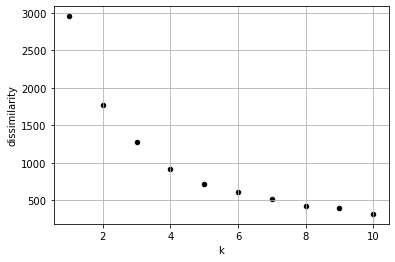

In [33]:
#dissimilaridade

execution_centroids = elbow_method(sample,'euc', 1000)


In [40]:
# !not automated!
#After visual analyses of elbows' plot -> choose a k for the k_means -> below: select the best centroids returned from the elbow to that K
execution_k = list(filter(lambda x:x["k"] == 4, execution_centroids ))
best_init_centroids = execution_k[0]['centroids']
print(best_init_centroids)

[{'centroid': '0', 'Workaholism': 4.511363636363637, 'Finances': 1.625}, {'centroid': '1', 'Workaholism': 4.457364341085271, 'Finances': 3.697674418604651}, {'centroid': '2', 'Workaholism': 2.1137440758293837, 'Finances': 1.5639810426540284}, {'centroid': '3', 'Workaholism': 2.280353200883002, 'Finances': 3.5916114790286975}]


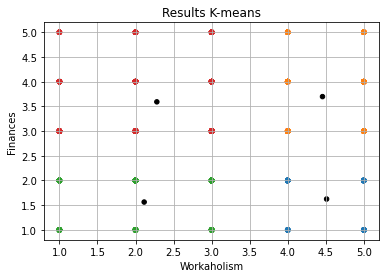

In [41]:
#main

#read dataset
#pandas can read from txt files. As our files are typed with tabs '\t', we can use that as separators

# dataset = pd.read_csv("dataset/MusicAndMovies_Vars.txt", sep="\t", header=0)
# dataset.insert(0,'centroid', 'empty')
# sample = dataset.sample(n=len(dataset))
# sample = sample.reset_index(drop=True)

k_param = 4
centroids = k_means(sample, k_param, "euc", 1000, best_init_centroids)

# centroids = best_init_centroids

# plot k-means
dfn = pd.DataFrame(centroids)
dfn = dfn.append(sample, ignore_index=True)

colors = ['black'] * k_param

for i in range(len(sample)):
  c = sample.iloc[i]['centroid']
  colors.append('C'+c)


plot_dataset(dfn, x='Workaholism', y='Finances', color=colors, title='Results K-means')


In [36]:
# Test PCA 2D

# df = pd.read_csv(path+"dataset/MusicAndMovies_Vars.txt", sep="\t", header=0)
# df.insert(0,'centroid', 'empty')

# sample = df[['centroid', "Pop",	"Rock", "Romantic"]]
# sample = sample.sample(n=len(sample))
# sample = sample.reset_index(drop=True)

# elbow_method(sample,'euc', 1000)

k_param = 4
centroids = k_means(sample, k_param, "euc", 1000, best_init_centroids)

centroids = best_init_centroids

X = sample[[ 
     'Music', 
    # 'Metal.or.Hardrock', 'Reggae..Ska', 'Techno..Trance',
    'Movies', 
    # 'Horror', 'Comedy', 'Sci.fi',
    'Politics', 
    # 'Mathematics', 
    # 'Shopping', 'Science.and.technology'
]]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=sample['centroid'])
fig.show()


KeyError: "None of [Index(['Music', 'Movies', 'Politics'], dtype='object')] are in the [columns]"

In [ ]:
# Test PCA 3D

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2,  color=sample['centroid'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [ ]:
# read dataset

dataset = pd.read_csv('dataset/USArrests.csv', header=0)

df = dataset
df.rename(columns={'Unnamed: 0':'name'}, inplace=True)

df = df[['name', 'Assault', 'Murder']]

# infos
print("Dataset Infos")
print(df.describe())
print_line()

# plot dataset
plot_dataset(df, x='Murder', y='Assault', color='black', title='Dataset')


# add column
df.insert(0,'centroid', 'empty')

# first dataset rows
print(df[:5])
print_line()

In [ ]:
# TESTs
k_param = 6

# """
# Test distance
xi = pd.DataFrame([{'x': 0.50, 'y': 0.43}])
xj = {'x': 1.00, 'y': 0.57}

print("Test distance method:")
for mode in ['euc', 'ave', 'man']:
  print("dist {} = {}".format(mode, distance(xi, xj, mode)))
print_line()

# Test init centroids
print("Test random init centroids method:")
centroids = init_centroids(df, k_param);
print(centroids)
print_line()

# Test min center
print("Test min centroid:")
sample = df.sample(n=1)
dfn = sample
# plot_dataset(dfn, x='Murder', y='Assault', color='red')

dfn = dfn.append(pd.DataFrame(centroids), ignore_index=True)


print(dfn)
print_line()

min = min_centroid(sample, centroids, 'euc')
print(min)


# plot color min center
colors = ['r']

for i in range(len(centroids)):
  if i == min:
    c = 'g'
  else:
    c = 'b'
  colors.append(c)

plot_dataset(dfn, x='Murder', y='Assault', color=colors, title='Example Centroids')
print_line()

# """

In [ ]:
# Test kmeans
k_param = 3
sample = df.sample(n=len(df))
sample = sample.reset_index(drop=True)
centroids = k_means(sample, k_param, 'euc', 1000)

print("best centroids:")
print(centroids)
print_line()

# plot k-means
dfn = pd.DataFrame(centroids)
dfn = dfn.append(sample, ignore_index=True)

colors = ['black'] * k_param

for i in range(len(sample)):
  c = sample.iloc[i]['centroid']
  colors.append('C'+c)

plot_dataset(dfn, x='Murder', y='Assault', color=colors, title='Results K-means')
print_line()
